# RUBRIC@ TREC RAG 24


**RUBRIC evaluation result analysis**

### Augmentation Task  (Concat)


This notebook is part of the RUBRIC-trec-rag repository: 
<https://github.com/TREMA-UNH/rubric-trec-rag>

Data Files available from the Online Appendix:  <https://trec-car.cs.unh.edu/rubric-trec-rag24/index.html>

**Use via Colab, jupyter, or similar**

1. Open notebook from github repository
2. Uncomment and run the cell with
```
    !pip install exam-pp
    !pip install rubric-trec-rag
```
3. Run remaining cells in notebook


**Alternative: Use via Nix**

*Installation:*

1. check out the respository
2. install `nix` from <https://nixos.org/download/>  (not NixOS!)
3. follow instructions in repository [readme](https://github.com/TREMA-UNH/rubric-trec-rag/)

*Usage via Nix:*

4. configure python environment with dependencies by calling
```
    nix develop
```
5. start jupyter notebook server with
```
    jupyter notebook
```
6. open this notebook and run all cells

In [ ]:
#!pip install exam-pp
#!pip install rubric-trec-rag

In [3]:
import exam_pp
import rubric_trec_rag
from pathlib import Path
import numpy
import pandas as pd
import scipy

from exam_pp.exam_cover_metric import *
from scipy.stats._result_classes import TtestResult

from rubric_trec_rag.export_rag_gen_as_run import *
from exam_pp.exam_evaluation import *

[nltk_data] Downloading package stopwords to /home/dietz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/dietz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Device = None; BATCH_SIZE = 1


In [4]:
DATA=Path("./data")
promptclass="QuestionSelfRatedUnanswerablePromptWithChoices"

rubric_final_concat_auggen=DATA / "questions-rate--rubric-rag24-concat_auggen.jsonl.gz"
rubric_final_gen=DATA / "questions-rate--rubric-rag24-gen.jsonl.gz"
rubric_final_auggen=DATA / "questions-rate--rubric-rag24-auggen.jsonl.gz"
rubric_final_retrieval=DATA / "questions-rate--rubric-rag24-retrieval.jsonl.gz"

rubric_final = rubric_final_concat_auggen


ungraded_base = plot_file = rubric_final.with_name(f"{rubric_final.stem}")

runs = rubric_final.with_name(f"{rubric_final.stem}-runs")
qrels = rubric_final.with_suffix(".qrel")
export_file = rubric_final.with_suffix(".export.tsv")
all_leaderboard_file = rubric_final.with_suffix(".leaderboard.tsv")
archive = rubric_final.with_suffix(".results.tar.gz")

runs, qrels, export_file, all_leaderboard_file, archive

(PosixPath('data/questions-rate--rubric-rag24-concat_auggen.jsonl-runs'),
 PosixPath('data/questions-rate--rubric-rag24-concat_auggen.jsonl.qrel'),
 PosixPath('data/questions-rate--rubric-rag24-concat_auggen.jsonl.export.tsv'),
 PosixPath('data/questions-rate--rubric-rag24-concat_auggen.jsonl.leaderboard.tsv'),
 PosixPath('data/questions-rate--rubric-rag24-concat_auggen.jsonl.results.tar.gz'))

In [5]:
rubric_final

PosixPath('data/questions-rate--rubric-rag24-concat_auggen.jsonl.gz')

In [8]:
# obtain rubric graded files
! mkdir -p {DATA}

!wget -nc https://trec-car.cs.unh.edu/rubric-trec-rag24/questions-rate--rubric-rag24-concat-auggen.jsonl.gz -O {rubric_final_concat_auggen}

# !wget -nc https://trec-car.cs.unh.edu/rubric-trec-rag24/questions-rate--rubric-rag24-auggen.jsonl.gz -O {rubric_final_auggen}
# !wget -nc https://trec-car.cs.unh.edu/rubric-trec-rag24/questions-rate--rubric-rag24-gen.jsonl.gz -O {rubric_final_gen}
# !wget -nc https://trec-car.cs.unh.edu/rubric-trec-rag24/questions-rate--rubric-rag24-retrieval.jsonl.gz -O {rubric_final_retrieval}

--2024-11-18 00:40:32--  https://trec-car.cs.unh.edu/rubric-trec-rag24/questions-rate--rubric-rag24-concat-auggen.jsonl.gz
Resolving trec-car.cs.unh.edu (trec-car.cs.unh.edu)... 132.177.4.88
Connecting to trec-car.cs.unh.edu (trec-car.cs.unh.edu)|132.177.4.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5847926 (5.6M) [application/x-gzip]
Saving to: ‘data/questions-rate--rubric-rag24-concat_auggen.jsonl.gz’

data/questions-rate 100%[===================>]   5.58M  1.49MB/s    in 3.7s    

2024-11-18 00:40:35 (1.49 MB/s) - ‘data/questions-rate--rubric-rag24-concat_auggen.jsonl.gz’ saved [5847926/5847926]



In [10]:
# num graded queries
!zcat {rubric_final} | wc -l

301


# Load Rubric data

In [11]:
def exam_grades(model, prompt_class, question_set, exam_graded_file):
    '''
    Load grades and paragraphs from RUBRIC internal file format
    '''
    grade_filter = GradeFilter(model_name=model, prompt_class = prompt_class, is_self_rated=None, min_self_rating=None, question_set=question_set, prompt_type=get_prompt_type_from_prompt_class(prompt_class))
    exam_input_file=exam_graded_file
    query_paragraphs:List[QueryWithFullParagraphList] = parseQueryWithFullParagraphs(exam_input_file)
    return query_paragraphs


# Open graded file and inspect exam grades

Json Example

```json
[
  "2024-145979",
  [
    {
      "paragraph_id": "b504cab1b522f7906c0abb44c30f4cd7",
      "text": "Vicarious trauma refers to the emotional and psychological impact experienced by individuals who are indirectly exposed to others' traumatic experiences.",
      "paragraph_data": {
        "judgments": [],
        "rankings": [
          {
            "method": "according-useful",
            "paragraphId": "b504cab1b522f7906c0abb44c30f4cd7",
            "queryId": "2024-145979",
            "rank": 1,
            "score": 1.0
          }
        ]
      },
      "exam_grades": [
        {
          "correctAnswered": [
            "2024-145979/ccc217319305b84a7a73db16d1d3d52d",
            "2024-145979/899180b0ca4b7daf548fc3b1d74c6917",
            "2024-145979/36b39eb1b546f06082fa99a07883a4ca",
            "2024-145979/06ff2a4f1e4869fe26dd034679403bad",
            "2024-145979/9b20f574516d894404136a8829b535d9",
            "2024-145979/dae1cd1ab183da5804311e764b1987d0",
            "2024-145979/bd8cc33b944bc940b9ed6a49c0f4502a",
            "2024-145979/40ee972ed1298a8b6e4894467c1a9dc4",
            "2024-145979/c8271d09bfd0b289d93ea501b129f308"
          ],
          "wrongAnswered": [
            "2024-145979/87c4cb0bd3430af2fc39ee05959e6abb"
          ],
          "answers": [
            [
              "2024-145979/ccc217319305b84a7a73db16d1d3d52d",
              "5\nExplanation: The passage provides a clear and comprehensive overview of vicarious trauma, including common symptoms such as emotional exhaustion, detachment, and cynicism. The passage also explains the potential long-term effects of
 vicarious trauma on individuals, making it a highly relevant and accurate answer to the question."
            ],
            [
              "2024-145979/899180b0ca4b7daf548fc3b1d74c6917",
              "5\nExplanation: The passage provides a clear and accurate definition of vicarious trauma, which is distinct from burnout. It explains that vicarious trauma is the emotional and psychological impact experienced by individuals who are in
directly exposed to others' traumatic experiences. This answer is highly relevant, complete, and accurate, as it directly addresses the question and provides a clear distinction between vicarious trauma and burnout."
            ],
            [
              "2024-145979/87c4cb0bd3430af2fc39ee05959e6abb",
              "The passage does not directly address the question, but it does provide some relevant information about vicarious trauma and its effects. The passage does not provide specific coping strategies for dealing with vicarious trauma. Howeve
r, it does suggest that it is important to recognize the impact of vicarious trauma and to seek support when needed. The passage also mentions that vicarious trauma can be mitigated by developing a sense of control and by engaging in activities that 
promote a sense of well-being. Overall, the passage provides some"
            ],
            [
              "2024-145979/36b39eb1b546f06082fa99a07883a4ca",
              "5. The passage directly addresses the impact of vicarious trauma on personal relationships outside of work, providing a clear and accurate answer to the question. It highlights the potential for vicarious trauma to affect relationships with family and friends, as well as the importance of self-care and support networks in mitigating its effects. The passage provides a comprehensive and relevant answer to the question."
            ],
            [
              "2024-145979/06ff2a4f1e4869fe26dd034679403bad",
              "5\nExplanation: The passage clearly states that professional therapy or counseling is usually recommended for those experiencing vicarious trauma, as it can help them process and cope with their emotions. The passage also mentions that vicarious trauma can have long-lasting effects if left untreated. The answer is highly relevant, complete, and accurate, earning a rating of 5."
            ],
            [
              "2024-145979/9b20f574516d894404136a8829b535d9",
              "4\nExplanation: The passage provides some relevant information about vicarious trauma, such as its definition and the potential effects on individuals. However, it does not offer specific strategies or recommendations for organizations to better support individuals who may be experiencing vicarious trauma. Therefore, the answer is mostly relevant and complete but may have minor gaps or inaccuracies."
            ],
            [
              "2024-145979/dae1cd1ab183da5804311e764b1987d0",
              "4\nExplanation: The passage discusses the importance of self-care for individuals who have been exposed to others' traumatic experiences, but it does not provide a comprehensive overview of the role of self-care in coping with vicarious trauma. It mentions that self-care can help individuals develop resilience and reduce the risk of burnout, but it does not elaborate on the specific ways in which self-care can be used to cope with vicarious trauma. The passage also does not provide any concrete examples or strategies for incorporating"
            ],
            [
              "2024-145979/bd8cc33b944bc940b9ed6a49c0f4502a",
              "4\nExplanation: The passage does not directly answer the question, but it provides some relevant information about the concept of vicarious trauma and its effects. It mentions that vicarious trauma can occur in various settings, including healthcare, social services, and education. However, it does not specifically mention industries or professions that are more prone to vicarious trauma. Therefore, the answer is rated as 4, indicating that the passage is mostly relevant and complete but lacks specific information on the topic."
            ],
            [
              "2024-145979/40ee972ed1298a8b6e4894467c1a9dc4",
              "4. The passage provides a general understanding of vicarious trauma and its impact, but it does not specifically address how individuals can identify their own triggers for vicarious trauma. The reader would need to look elsewhere for more detailed information on this topic. However, the passage does provide a good foundation for understanding the concept of vicarious trauma, which is a good starting point for further exploration."
            ],
            [
              "2024-145979/c8271d09bfd0b289d93ea501b129f308",
              "5\nExplanation: The passage provides a comprehensive overview of resources available for preventing and managing vicarious trauma in the workplace. It highlights the importance of creating a supportive work environment, providing training and education, and encouraging open communication. The passage also mentions the role of leadership and management in addressing vicarious trauma, as well as the need for ongoing support and resources for affected employees. Overall, the passage provides a thorough and accurate answer to the question."
            ]
          ],
          "llm": "meta-llama/Meta-Llama-3-8B-Instruct",
          "llm_options": {},
          "exam_ratio": 0.9,
          "prompt_info": {
            "prompt_class": "QuestionSelfRatedUnanswerablePromptWithChoices",
            "orig_prompt_class": "unknown",
            "prompt_style": "Can the question be answered based on the available context? Choose one",
            "context_first": false,
            "check_unanswerable": true,
            "check_answer_key": false,
            "is_self_rated": true,
            "is_self_rater_tolerant": true
          },
           "self_ratings": [
            {
              "question_id": "2024-145979/ccc217319305b84a7a73db16d1d3d52d",
              "self_rating": 5
            },
            {
              "question_id": "2024-145979/899180b0ca4b7daf548fc3b1d74c6917",
              "self_rating": 5
            },
            {
              "question_id": "2024-145979/87c4cb0bd3430af2fc39ee05959e6abb",
              "self_rating": 0
            },
            {
              "question_id": "2024-145979/36b39eb1b546f06082fa99a07883a4ca",
              "self_rating": 5
            },
            {
              "question_id": "2024-145979/06ff2a4f1e4869fe26dd034679403bad",
              "self_rating": 5
            },
            {
              "question_id": "2024-145979/9b20f574516d894404136a8829b535d9",
              "self_rating": 4
            },
            {
              "question_id": "2024-145979/dae1cd1ab183da5804311e764b1987d0",
              "self_rating": 4
            },
            {
              "question_id": "2024-145979/bd8cc33b944bc940b9ed6a49c0f4502a",
              "self_rating": 4
            },
            {
              "question_id": "2024-145979/40ee972ed1298a8b6e4894467c1a9dc4",
              "self_rating": 4
            },
            {
              "question_id": "2024-145979/c8271d09bfd0b289d93ea501b129f308",
              "self_rating": 5
            }
          ],
          "prompt_type": "question"
        }
      ]
    },

```

In [12]:
print(f"rubric file: {rubric_final}")
# load grades from rubric file
examgrades = exam_grades(model=None, prompt_class=promptclass, question_set="question-bank", exam_graded_file=rubric_final)

rubric file: data/questions-rate--rubric-rag24-concat_auggen.jsonl.gz


In [13]:
# example for inspecting RUBRIC grading results

for result in examgrades[0:1]: # just first query
    result: QueryWithFullParagraphList
    queryId=result.queryId
    paragraphs=result.paragraphs
    print(f"query = {result.queryId}")

    for paragraph in paragraphs[0:10]:  # just first ten paragraphs
        paragraph: FullParagraphData
        paragraph_id = paragraph.paragraph_id
        text = paragraph.text
        # judgments = paragraph.paragraph_data.judgments if paragraph.paragraph_data else []  # manual judgments currently not available for RAG
        rankings = paragraph.paragraph_data.rankings if paragraph.paragraph_data else [] # which system retrieved this paragraph?
        print("\n")
        print(paragraph_id)
        print(text)
        print(rankings)
        for grades in paragraph.exam_grades:
            grades: ExamGrades
            # self_ratings are the numerical grade (0-5) for each question-style nugget
            # answers are the raw output we received from the grading LLM
            for (r, a) in zip(grades.self_ratings, grades.answers): 
                print(r.question_id, r.self_rating, 'raw_answer: ',a)

query = 2024-105741


e24bbfbe6e9e1f3ab77b16e795179cb2
A white blood cell count (WBC) over 15,000 without treatment is not necessarily dangerous in itself, but it can be a sign of an underlying infection or inflammation that requires medical attention. 
A WBC count of 15,000 is considered elevated, and it may indicate that your body is fighting an infection or responding to an inflammatory process.


In the context of your situation, having a WBC count of 15,000 without treatment may be a sign that your body is trying to fight off an infection that was not fully resolved with the initial treatment. 
It's possible that the infection is still present, or that there is another underlying cause for the elevated WBC count.


It's important to note that a WBC count of 15,000 is not necessarily a cause for concern, but it does require further evaluation to determine the underlying cause. 
Your doctor may recommend additional testing, such as a complete blood count (CBC) or other diagnostic te

In [14]:
# rubric  json schema
print("queryId, list of...")

print(FullParagraphData.schema_json(indent=2))

queryId, list of...
{
  "title": "FullParagraphData",
  "type": "object",
  "properties": {
    "paragraph_id": {
      "title": "Paragraph Id",
      "type": "string"
    },
    "text": {
      "title": "Text",
      "type": "string"
    },
    "paragraph": {
      "title": "Paragraph"
    },
    "paragraph_data": {
      "$ref": "#/definitions/ParagraphData"
    },
    "exam_grades": {
      "title": "Exam Grades",
      "type": "array",
      "items": {
        "$ref": "#/definitions/ExamGrades"
      }
    },
    "grades": {
      "title": "Grades",
      "type": "array",
      "items": {
        "$ref": "#/definitions/Grades"
      }
    }
  },
  "required": [
    "paragraph_id",
    "text",
    "paragraph_data"
  ],
  "definitions": {
    "Judgment": {
      "title": "Judgment",
      "type": "object",
      "properties": {
        "paragraphId": {
          "title": "Paragraphid",
          "type": "string"
        },
        "query": {
          "title": "Query",
          "typ

# Extract leaderboards


RUBRIC-cover:
1. run `export_rag_rubric_cover_leaderboard`


RUBRIC-qrels:
1. convert run files from rubric files  (`export_rag_gen_as_run_main`)
2. produce leaderboard with trec_eval


Manual production of RUBRIC-qrels
1. convert run files from rubric files (`export_rag_gen_as_run_main`)
2. export qrels file  (`export_qrels`)
3. run trec_eval (or similar) manually 


### Convert run files

(this may take a moment)

In [15]:
def export_rag_gen_as_run_main(rubric_graded_file, run_out):
    # now emit the input files for RUBRIC/EXAM
    rubric_data:List[QueryWithFullParagraphList] 
    # rubric_data = parseQueryWithFullParagraphs(rubric_graded_file)
    rubric_data = examgrades

    run_entry_per_method:Dict[str,List[ParagraphRankingEntry]] = defaultdict(list)

    # collect ranking entries
    for entry in rubric_data:
        for para in entry.paragraphs:
            for rankEntry in para.paragraph_data.rankings:
                run_entry_per_method[rankEntry.method].append(rankEntry)

    runDir:Path = run_out
    
    # create dir if necessary
    runDir.mkdir(exist_ok=True)
    
    # delete old files
    for file in runDir.iterdir():
        if file.is_file():
            file.unlink()

    # write as trec_eval compatible run files
    for method,rankEntries in run_entry_per_method.items():
        sorted_ranking_entries = sorted(rankEntries, key=attrgetter('queryId','rank'))
        unique_sorted_ranking_entries = remove_duplicates_by_key(sorted_ranking_entries, key_func=lambda r: (r.queryId, r.paragraphId))
        
        runFile = runDir/(f'{method}.run')
        if(runFile.exists()):
            print(f"Overwriting {runFile.absolute()}")
        else: 
            print(f"Exporting to {runFile.absolute()}")
        export_run_file(run_file=runFile, ranking_entries=unique_sorted_ranking_entries)

    return unique_sorted_ranking_entries 

In [16]:
res = export_rag_gen_as_run_main(rubric_final, runs)
res[0:10]

Exporting to /home/dietz/trec-car/exampp/rubric-trec-rag/data/questions-rate--rubric-rag24-concat_auggen.jsonl-runs/agricultural-cloth.run
Exporting to /home/dietz/trec-car/exampp/rubric-trec-rag/data/questions-rate--rubric-rag24-concat_auggen.jsonl-runs/alive-start.run
Exporting to /home/dietz/trec-car/exampp/rubric-trec-rag/data/questions-rate--rubric-rag24-concat_auggen.jsonl-runs/ally-what.run
Exporting to /home/dietz/trec-car/exampp/rubric-trec-rag/data/questions-rate--rubric-rag24-concat_auggen.jsonl-runs/alter-stir.run
Exporting to /home/dietz/trec-car/exampp/rubric-trec-rag/data/questions-rate--rubric-rag24-concat_auggen.jsonl-runs/angle-heel.run
Exporting to /home/dietz/trec-car/exampp/rubric-trec-rag/data/questions-rate--rubric-rag24-concat_auggen.jsonl-runs/blame-governor.run
Exporting to /home/dietz/trec-car/exampp/rubric-trec-rag/data/questions-rate--rubric-rag24-concat_auggen.jsonl-runs/brush-plot.run
Exporting to /home/dietz/trec-car/exampp/rubric-trec-rag/data/questions

[ParagraphRankingEntry(method='zero-relax', paragraphId='7cc7637b55fe2e8ac0ebd7887f54a04b', queryId='2024-105741', rank=1, score=1.0),
 ParagraphRankingEntry(method='zero-relax', paragraphId='0957803cf0ed709a89fbdf802dde70ee', queryId='2024-109837', rank=1, score=1.0),
 ParagraphRankingEntry(method='zero-relax', paragraphId='566b68b4bcff40dec84749a9f1b88687', queryId='2024-111331', rank=1, score=1.0),
 ParagraphRankingEntry(method='zero-relax', paragraphId='7867208d50c63736c7392e5d3dc244d3', queryId='2024-111506', rank=1, score=1.0),
 ParagraphRankingEntry(method='zero-relax', paragraphId='78441a0e2a5d431cafbcb85feccc031d', queryId='2024-113215', rank=1, score=1.0),
 ParagraphRankingEntry(method='zero-relax', paragraphId='f5a184c647d97d7e9d5058d68d950eab', queryId='2024-113646', rank=1, score=1.0),
 ParagraphRankingEntry(method='zero-relax', paragraphId='888897cde96425ef302db4c42cf5052e', queryId='2024-114095', rank=1, score=1.0),
 ParagraphRankingEntry(method='zero-relax', paragraphId

# Export Leaderboard

In [17]:
# If multiple grading configuration are in the same rubric file, 
# then use this grade filter to select a particular LLM model (e.g. "google/flan-t5-large")
# or grading prompt (e.g. "QuestionSelfRatedUnanswerablePromptWithChoices" or "NuggetSelfRatedPrompt")
# or question set (e.g. "question-bank")
# or prompt_type (e.g "question", "nugget", or "direct")

grade_filter = GradeFilter(model_name=None, prompt_class = promptclass, is_self_rated=None, min_self_rating=None, question_set="question-bank", prompt_type=get_prompt_type_from_prompt_class(promptclass))

## Export qrels for RUBRIC-Qrels or manual trec_eval

In [18]:
# function to export qrels
def export_qrels(examgrades, qrel_out, prompt_class, model):
    grade_filter = GradeFilter(model_name=model, prompt_class = prompt_class, is_self_rated=None, min_self_rating=None, question_set="question-bank", prompt_type=get_prompt_type_from_prompt_class(prompt_class))

    exam_pp.exam_evaluation.export_qrels(query_paragraphs=examgrades
             , qrel_out_file=qrel_out
             , grade_filter=grade_filter
             , use_query_facets=False
             , use_ratings=True  # answerability grades
             , direct_grading=False
             )


In [19]:
# perform export
export_qrels(examgrades, qrels, promptclass,model=None)


In [42]:
# Verify exported qrel content

!head {qrels}

2024-105741 0 e24bbfbe6e9e1f3ab77b16e795179cb2 4
2024-105741 0 50e0e6b2a9db3d89ad986afe9a3f60b4 4
2024-105741 0 d40cf07941601c2903a2817deb477b97 5
2024-105741 0 da2853f7047795a6db3585d986847e15 4
2024-105741 0 d2f7c6ee5bc611acb3fb99978bcf4ae7 4
2024-105741 0 05f615263ecf746ce9948cd7a884660d 4
2024-105741 0 9c4ea9d318519c2ccb197e12533ac4b9 4
2024-105741 0 4ae50041cd68470cf783ed1799cd0e12 4
2024-105741 0 7bf8f551181e5f9fa73458f9f3d60c9c 5
2024-105741 0 cdb22dee72af0df455a67646fa5aa4d0 4


## Export individual RUBRIC leaderboards

You can skip forward to the next section, if you don't want to create additional leaderboards.

In [21]:
minrating = 4

cover_board= rubric_final.with_name(f"{rubric_final.stem}-cover-{minrating}").with_suffix(".tsv")
qrels_board= rubric_final.with_name(f"{rubric_final.stem}-qrels-{minrating}").with_suffix(".tsv")

In [22]:
# functions to export a RUBRIC-Cover Leaderboard

# Alternatives to produce leaderboard
# python -O -m exam_pp.exam_evaluation $DATA/$rubric_final --question-set question-bank --prompt-class $promptclass --min-self-rating $minrating --leaderboard-out $DATA/$cover_board.tsv

# exam_pp.exam_evaluation.run_leaderboard(leaderboard_file=cover_board
#                         , grade_filter=grade_filter
#                         , query_paragraphs=examgrades
#                         , min_self_rating=minrating
#                         , leaderboard_sort=None
#                         )


def cover_leaderboard(leaderboard_file, examgrades, minrating, leaderboard_sort:Optional[str])-> Dict[str,exam_pp.exam_cover_metric.ExamCoverEvalsDict]:
    '''
    Computes query-wise RUBRIC-cover score
    writes a tsv file with mean and stderr to `leaderboard_file`
    returns a dictionary of MethodName to `ExamCoverEvalsDict`
    '''
    exam_factory = ExamCoverScorerFactory(grade_filter=grade_filter, min_self_rating=minrating)
    resultsPerMethod:Dict[str, ExamCoverEvals] = compute_exam_cover_scores(examgrades, exam_factory=exam_factory)
    export_leaderboard_table(leaderboard_out=leaderboard_file, evals= list(resultsPerMethod.values()), sortBy=leaderboard_sort)
    return resultsPerMethod

In [23]:
# function to export a RUBRIC-qrels leaderboard
from exam_pp.exam_run_trec_eval import *

def qrels_leaderboard(leaderboard_file, run_dir, qrels,  examgrades, minrating, trec_eval_metric, leaderboard_sort:Optional[str])-> Dict[str,exam_pp.exam_cover_metric.ExamCoverEvalsDict]:
    resultsPerMethod:Dict[str, ExamCoverEvals]
    
    trec_eval_out =run_trec_eval_variance(run_dir=run_dir, qrels=qrels, min_level=minrating, trec_eval_metric=trec_eval_metric)
    trec_eval_parsed=parse_trec_eval_variance(trec_eval_out)
    resultsPerMethod = compute_exam_qrels_scores(trec_eval_parsed)
    
    # exam_leaderboard_correlation.print_leaderboard_eval(evals = list(resultsPerMethod.values()), grade_filter=grade_filter)
    export_leaderboard_table(leaderboard_out=leaderboard_file, evals= list(resultsPerMethod.values()), sortBy=leaderboard_sort)
    return resultsPerMethod

In [24]:
# Because TREC RAG segment Ids contain `#`
# which is considered a reserved comment char in trec_eval, 
# we have to patch all generated run/qrel files to get rid of it.

import subprocess

print(runs)
subprocess.run(["find", runs, "-type", "f", "-exec", "sed", "-i", "s/#//g", "{}", "+"])

print(qrels)
subprocess.run(["sed", "-i", "s/#//g", qrels])

data/questions-rate--rubric-rag24-concat_auggen.jsonl-runs
data/questions-rate--rubric-rag24-concat_auggen.jsonl.qrel


CompletedProcess(args=['sed', '-i', 's/#//g', PosixPath('data/questions-rate--rubric-rag24-concat_auggen.jsonl.qrel')], returncode=0)

In [25]:
# example of individual leaderboards

# cover_result = cover_leaderboard(leaderboard_file=cover_board, examgrades=examgrades,minrating= minrating, leaderboard_sort=None)
qrel_result = qrels_leaderboard(leaderboard_file=qrels_board, run_dir=runs, qrels = qrels
                                , examgrades=examgrades, minrating= minrating, trec_eval_metric="P.20"
                                , leaderboard_sort=None)

Running trec_eval command:
for f in *.run; do  res=`trec_eval -n -c -q -m P.20  -l 4  /home/dietz/trec-car/exampp/rubric-trec-rag/data/questions-rate--rubric-rag24-concat_auggen.jsonl.qrel $f`; echo "$f $res"; done
in directory: data/questions-rate--rubric-rag24-concat_auggen.jsonl-runs
OVERALL EXAM-qrels method _overall_: avg examScores 0.00 +/0 0.000
OVERALL EXAM-qrels method agricultural-cloth: avg examScores 0.05 +/0 0.001
OVERALL EXAM-qrels method alive-start: avg examScores 0.04 +/0 0.001
OVERALL EXAM-qrels method ally-what: avg examScores 0.05 +/0 0.001
OVERALL EXAM-qrels method alter-stir: avg examScores 0.05 +/0 0.001
OVERALL EXAM-qrels method angle-heel: avg examScores 0.05 +/0 0.000
OVERALL EXAM-qrels method blame-governor: avg examScores 0.04 +/0 0.001
OVERALL EXAM-qrels method brush-plot: avg examScores 0.05 +/0 0.001
OVERALL EXAM-qrels method colour-sake: avg examScores 0.05 +/0 0.000
OVERALL EXAM-qrels method cooperation-rapid: avg examScores 0.05 +/0 0.001
OVERALL EXAM-

In [26]:
# Verify RUBRIC-qrels leaderboard output
!cat {qrels_board}

method	ExamCover	+/-	std-err
_overall_	0.000	+/-	0.000
agricultural-cloth	0.047	+/-	0.001
alive-start	0.041	+/-	0.001
ally-what	0.046	+/-	0.001
alter-stir	0.048	+/-	0.001
angle-heel	0.049	+/-	0.000
blame-governor	0.043	+/-	0.001
brush-plot	0.046	+/-	0.001
colour-sake	0.049	+/-	0.000
cooperation-rapid	0.046	+/-	0.001
corporation-heel	0.045	+/-	0.001
creature-contemporary	0.049	+/-	0.000
custom-belong	0.046	+/-	0.001
desire-originally	0.043	+/-	0.001
electronic-explain	0.048	+/-	0.001
engine-lifestyle	0.045	+/-	0.001
example-newspaper	0.045	+/-	0.001
flag-satellite	0.047	+/-	0.001
flavor-case	0.035	+/-	0.001
freeze-park	0.049	+/-	0.000
gene-chest	0.049	+/-	0.000
group-herself	0.049	+/-	0.000
headquarters-poem	0.047	+/-	0.001
include-signal	0.049	+/-	0.000
information-knee	0.047	+/-	0.001
instead-council	0.049	+/-	0.000
language-practical	0.049	+/-	0.000
look-print	0.046	+/-	0.001
love-volunteer	0.049	+/-	0.000
medication-pause	0.047	+/-	0.001
medium-custom	0.049	+/-	0.000
morning-monkey	

In [27]:
# example of computing mean +/- stderr per method

from exam_pp.exam_cover_metric import *
from scipy.stats._result_classes import TtestResult

def leaderboard_mean_stderr(leaderboard, method):
    '''
    Mean and stderr of a method (=system/run) under a RUBRIC-measure
    '''
    mean,stderr=systemMeanStderr(leaderboard[method].examCoverPerQuery.values())
    return mean,stderr

@dataclass
class ComparisonResult():
    mean1:float
    mean2:float
    ttest_result:TtestResult
    mean_diff:float

def leaderboard_paired_ttest(leaderboard, method1, method2):
    '''
    Are two methods (=systems/runs) significantly different under a RUBRIC-measure?
    '''
    values1 = numpy.array(list(leaderboard[method1].examCoverPerQuery.values()))
    values2 = numpy.array(list(leaderboard[method2].examCoverPerQuery.values()))

    mean1 = numpy.mean(values1)
    mean2 = numpy.mean(values2)
    t = scipy.stats.ttest_rel(values1, values2)
    mean_diff = numpy.mean(values1 - values2)

    return ComparisonResult(mean1=mean1, mean2=mean2, ttest_result=t,  mean_diff=mean_diff)

In [28]:
# example on how to access results and compute statistics

leader_result = qrel_result
# leader_result = cover_result

print(leader_result.keys())

method1 = list(leader_result.keys())[1] # 'space-traffic'
method2 = list(leader_result.keys())[7] #'pepper-highlight'

mean1,stderr1=leaderboard_mean_stderr(leader_result, method1)
mean2,stderr2=leaderboard_mean_stderr(leader_result, method2)
comparison=leaderboard_paired_ttest(leader_result, method1, method2)

print(f"{method1}: {mean1} +/- {stderr1}")
print(f"{method2}: {mean2} +/- {stderr2}")
print(f"{method1}: {comparison.mean1}   vs {method2}:{comparison.mean2}")
print(f"avg 1 better? {comparison.mean_diff}")
print(f"paired ttest: {comparison.ttest_result}")

dict_keys(['_overall_', 'agricultural-cloth', 'alive-start', 'ally-what', 'alter-stir', 'angle-heel', 'blame-governor', 'brush-plot', 'colour-sake', 'cooperation-rapid', 'corporation-heel', 'creature-contemporary', 'custom-belong', 'desire-originally', 'electronic-explain', 'engine-lifestyle', 'example-newspaper', 'flag-satellite', 'flavor-case', 'freeze-park', 'gene-chest', 'group-herself', 'headquarters-poem', 'include-signal', 'information-knee', 'instead-council', 'language-practical', 'look-print', 'love-volunteer', 'medication-pause', 'medium-custom', 'morning-monkey', 'naturally-best', 'nature-mixture', 'nearly-tired', 'neighborhood-enjoy', 'origin-sail', 'perfectly-solar', 'plant-taxpayer', 'raise-earnings', 'rose-manager', 'social-defensive', 'southern-favorite', 'steam-democratic', 'step-monitor', 'sweet-health', 'teen-gently', 'terror-shall', 'trial-seek', 'view-technique', 'virus-rush', 'welfare-conversation', 'writing-shift', 'zero-relax'])
agricultural-cloth: 0.0465116279

## Compute TREC RAG Leaderboards

We are computing five RUBRIC-leaderboards which we contribute in the TREC RAG'24 Evaluatuation

In [29]:
cover_result1 = cover_leaderboard(leaderboard_file=rubric_final.with_suffix(".cover-1.tsv"), examgrades=examgrades,minrating= 1, leaderboard_sort=None)
cover_result4 = cover_leaderboard(leaderboard_file=rubric_final.with_suffix(".cover-4.tsv"), examgrades=examgrades,minrating= 4, leaderboard_sort=None)
cover_result5 = cover_leaderboard(leaderboard_file=rubric_final.with_suffix(".cover-5.tsv"), examgrades=examgrades,minrating= 5, leaderboard_sort=None)

qrel_result_ndcg = qrels_leaderboard(leaderboard_file=rubric_final.with_suffix(".qrels-ndcg.tsv"), run_dir=runs, qrels = qrels
                                , examgrades=examgrades, minrating= 1, trec_eval_metric="ndcg_cut.20"
                                , leaderboard_sort=None)
qrel_result1 = qrels_leaderboard(leaderboard_file=rubric_final.with_suffix(".qrels-1.tsv"), run_dir=runs, qrels = qrels
                                , examgrades=examgrades, minrating= 1, trec_eval_metric="P.20"
                                , leaderboard_sort=None)
qrel_result4 = qrels_leaderboard(leaderboard_file=rubric_final.with_suffix(".qrels-4.tsv"), run_dir=runs, qrels = qrels
                                , examgrades=examgrades, minrating= 4, trec_eval_metric="P.20"
                                , leaderboard_sort=None)
qrel_result5 = qrels_leaderboard(leaderboard_file=rubric_final.with_suffix(".qrels-5.tsv"), run_dir=runs, qrels = qrels
                                , examgrades=examgrades, minrating= 5, trec_eval_metric="P.20"
                                , leaderboard_sort=None)

2024-105741, overall ratio 1.0
2024-109837, overall ratio 1.0
2024-111331, overall ratio 1.0
2024-111506, overall ratio 0.9
2024-113215, overall ratio 1.0
2024-113646, overall ratio 1.0
2024-114095, overall ratio 1.0
2024-121840, overall ratio 1.0
2024-126056, overall ratio 1.0
2024-126326, overall ratio 1.0
2024-126414, overall ratio 0.9
2024-127266, overall ratio 0.9
2024-127288, overall ratio 1.0
2024-127349, overall ratio 1.0
2024-127653, overall ratio 0.9
2024-128311, overall ratio 1.0
2024-12875, overall ratio 0.9
2024-128784, overall ratio 0.9
2024-129062, overall ratio 1.0
2024-129925, overall ratio 1.0
2024-131116, overall ratio 1.0
2024-133137, overall ratio 0.8
2024-133810, overall ratio 1.0
2024-134629, overall ratio 1.0
2024-134815, overall ratio 1.0
2024-134964, overall ratio 1.0
2024-135747, overall ratio 1.0
2024-136156, overall ratio 1.0
2024-137182, overall ratio 1.0
2024-137315, overall ratio 1.0
2024-137667, overall ratio 1.0
2024-138052, overall ratio 1.0
2024-1412

In [59]:
# collect leaderboards from different RUBRIC measures

boards={
    "cover-1": cover_result1
    , "cover-4": cover_result4
    , "cover-5": cover_result5
    # , "qrels-ndcg": qrel_result_ndcg
    # , "qrels-1": qrel_result1
    # , "qrels-4": qrel_result4
    # , "qrels-5": qrel_result5
}

In [60]:
# Export system evaluation scores per system/query/measure

@dataclass
class RunMeasureTopicValue():
    run:str
    measure:str
    topic:str
    value:float

# function to run the export
def export_method_measure_topic_value_format(boards:Dict[str, ExamCoverEvals]):
    export_lines = list()
    for measure, cover_evals_dict in boards.items():
        for method, cover_evals in cover_evals_dict.items():
            lines = [RunMeasureTopicValue(run=cover_evals.method, measure=measure, topic=topic, value=v) 
                         for topic, v in cover_evals.examCoverPerQuery.items()
                         # if cover_evals.method != "_overall_"
                   ]
            export_lines.extend(lines)
    return export_lines

# perform export
lines = export_method_measure_topic_value_format(boards)
with open(export_file, "wt") as file:
    file.write("\n".join( [ f"{line.run}\t{line.measure}\t{line.topic}\t{line.value}" for line in lines]))
    file.flush()

# example output
lines[0:10000:300]

[RunMeasureTopicValue(run='_overall_', measure='cover-1', topic='2024-105741', value=1.0),
 RunMeasureTopicValue(run='_overall_', measure='cover-1', topic='2024-96485', value=0.9),
 RunMeasureTopicValue(run='agricultural-cloth', measure='cover-1', topic='2024-96359', value=0.8),
 RunMeasureTopicValue(run='alive-start', measure='cover-1', topic='2024-96063', value=0.8),
 RunMeasureTopicValue(run='ally-what', measure='cover-1', topic='2024-94706', value=0.5),
 RunMeasureTopicValue(run='alter-stir', measure='cover-1', topic='2024-90454', value=0.7),
 RunMeasureTopicValue(run='angle-heel', measure='cover-1', topic='2024-88894', value=0.3),
 RunMeasureTopicValue(run='blame-governor', measure='cover-1', topic='2024-79154', value=0.9),
 RunMeasureTopicValue(run='brush-plot', measure='cover-1', topic='2024-79129', value=0.6),
 RunMeasureTopicValue(run='colour-sake', measure='cover-1', topic='2024-79113', value=0.7),
 RunMeasureTopicValue(run='cooperation-rapid', measure='cover-1', topic='2024-

## Leaderboard Plotting code

In [61]:
import pandas as pd
def leaderboard_to_dataframe(leaderboard):
    out = [(method, mean, stderr)
       for method in leaderboard.keys() if method != "_overall_"
       for mean, stderr in [leaderboard_mean_stderr(leaderboard, method)]
      ]
    return pd.DataFrame(out, columns=['method', 'mean', 'stderr']).set_index('method')

def join_leaderboards(boards: Dict[str,pd.DataFrame], sort_by_board:str):
    data = pd.concat(boards, names=['evals'], axis=1)
    data = data.swaplevel(0,1, axis=1)
    data = data.sort_values(by=("mean",sort_by_board), ascending=False)
    return data

In [64]:
# convert leaderboards to pandas data frames

df_boards={key:leaderboard_to_dataframe(val) for key,val in boards.items()}
# leaderboard_df = join_leaderboards(df_boards, sort_by_board="qrels-ndcg")
leaderboard_df_cover = join_leaderboards(df_boards, sort_by_board="cover-4")
leaderboard_df = leaderboard_df_cover

In [ ]:
# export as TSV
leaderboard_df.to_csv(all_leaderboard_file, sep='\t', index=True)

leaderboard_df

In [65]:
# Compute Min/Max/Med and inter-quartile ranges

quantiles = leaderboard_df.quantile([0.0,0.25, 0.5,0.75,0.85,1.0])

quantiles

,mean,stderr,mean,stderr,mean,stderr
evals,cover-1,cover-1,cover-4,cover-4,cover-5,cover-5
0.00,0.388077,0.011360,0.226246,0.013469,0.013621,0.002565
0.25,0.592718,0.011932,0.436951,0.014415,0.058472,0.007524
0.50,0.620487,0.013613,0.487154,0.015352,0.067442,0.007957
0.75,0.690392,0.014525,0.578456,0.015839,0.076744,0.008511
0.85,0.700744,0.014841,0.591641,0.016278,0.079656,0.008735
1.00,0.728967,0.016152,0.607624,0.017055,0.114225,0.010776


In [66]:
# Plot leaderboards with stderror

from matplotlib.lines import Line2D
import pathlib as path

def plot_leaderboard(leaderboard_df, file_ext=''):
    leaderboard_df.index =  leaderboard_df.index.astype(str).fillna("Unknown") 
    
    ax=leaderboard_df.plot.line(y='mean', yerr='stderr', color=["#ffaaaa", "#ff0000", "#ff7777", "#00aaaa", "#aaaaff", "#0000ff", "#7777ff" ],alpha=0.5, figsize=(12,6))
    ax.tick_params(axis='x', rotation=90, labelsize='small')
    ax.set_xticks(range(len(leaderboard_df)))
    ax.set_xticklabels(leaderboard_df.index, rotation=90, fontsize='small')
   
    quantiles = leaderboard_df.quantile([0.0,0.1, 0.5,0.75,0.85,1.0])
    
    data = leaderboard_df
    custom_legend = [Line2D([0], [0],  linestyle='None', marker='o', color='green',  label='> 85%')
                     , Line2D([0], [0],  linestyle='None', marker='.', color='green',  label='> 75%')]

  
    ax.legend(handles=custom_legend + ax.get_legend_handles_labels()[0], loc='upper left',bbox_to_anchor=(1.0, 1.0))
    
    for column in data.columns:
       if column[0]=="mean":
        ax.scatter(data.index, data[column].where(data[column] > quantiles.loc[0.85,column]), 
                   color='green', label=f"{column} > 85%", marker='o')
        ax.scatter(data.index, data[column].where(data[column] > quantiles.loc[0.75,column]), 
                   color='green', label=f"{column} > 75%", marker='.')
    
    
    fig = ax.get_figure()
    plot_file1 = rubric_final.with_name(f"{rubric_final.stem}_plot").with_suffix(f".leaderboard-plot{file_ext}.png")
    z = fig.savefig(plot_file1, dpi=300, bbox_inches='tight')
    
    fig = ax.get_figure()
    plot_file2 = rubric_final.with_name(f"{rubric_final.stem}_plot").with_suffix(f".leaderboard-plot{file_ext}.svg")
    z = fig.savefig(plot_file2, dpi=300, bbox_inches='tight')
    
    
    fig = ax.get_figure()
    plot_file3 = rubric_final.with_name(f"{rubric_final.stem}_plot").with_suffix(f".leaderboard-plot{file_ext}.pdf")
    z = fig.savefig(plot_file3, dpi=300, bbox_inches='tight')

    return fig, plot_file1, plot_file2, plot_file3

In [ ]:
# Plot sorted by qrels-ndcg
fig, plot_file1, plot_file2, plot_file3 = plot_leaderboard(leaderboard_df, "")

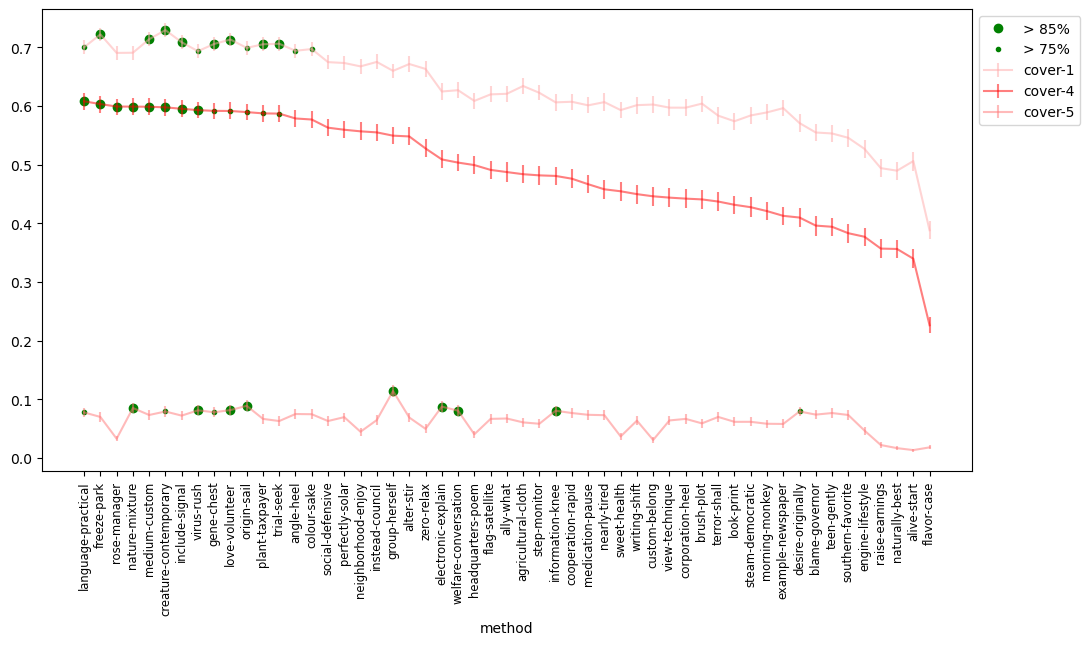

In [67]:
# Plot sorted by cover-4
fig, plot_file1x, plot_file2x, plot_file3x = plot_leaderboard(leaderboard_df_cover, "-cover4")

In [68]:
archive

PosixPath('data/questions-rate--rubric-rag24-concat_auggen.jsonl.results.tar.gz')

In [ ]:
# produce an archive of RUBRIC analysis result files for distribution

import subprocess

readme = DATA/"README.mkd"
subprocess.run(["tar","-czf",archive, runs,qrels, export_file, all_leaderboard_file, plot_file1, plot_file2, plot_file3, plot_file1x, plot_file2x, plot_file3x, readme])

# Analysis of Individual Systems

You can skip this section.

Choose queries (topics) and systems (runs) and display the retrieved/generated passages with positively graded rubric-questions.

In [69]:
div_method1="neighborhood-enjoy"
query_id="2024-105741"
minlevel=4

# inspect results
for result in examgrades[0:1]: # just first query
  if result.queryId==query_id:  # a particular query
    queryId=result.queryId
    paragraphs=result.paragraphs
    print(f"query = {result.queryId} / run = {div_method1}")

    correctly_answered=set()
    for paragraph in paragraphs:  # just first ten paragraphs
        paragraph_id = paragraph.paragraph_id
        text = paragraph.text
        rankings = paragraph.paragraph_data.rankings if paragraph.paragraph_data else [] # which system retrieved this paragraph?

        method1_rankings=[ r for r in rankings if r.method==div_method1 ]
        if (method1_rankings):
            rank = method1_rankings[0].rank
            if rank <= 20:
                print("\n")
                print("rank", rank)
                # print(paragraph_id)
                print(text)
                for grades in paragraph.exam_grades:
                    # self_ratings are the numerical grade (0-5) for each question-style nugget
                    # answers are the raw output we received from the grading LLM
                    for index, (r, a) in enumerate(zip(grades.self_ratings, grades.answers)): 
                        if r.self_rating >= minlevel:
                            print(f"Q{index+1}({r.self_rating})")
                            correctly_answered.add(f"Q{index+1}")
                            # print(index, r.question_id, r.self_rating)
                    print("-")
    print(f"correctly answered: {correctly_answered}")        

query = 2024-105741 / run = neighborhood-enjoy


rank 1
A white blood cell count over 15,000 is often indicative of an infection, which can be concerning. It's important to follow up with your doctor, as elevated WBCs can suggest ongoing infection or other health issues. Symptoms like hot flashes, sore joints, fatigue, and swollen lymph nodes further stress the need for medical evaluation and appropriate treatment.
A white blood cell (WBC) count over 15,000 can indicate an infection, as it is often a sign of the body's immune response. This condition, known as leukocytosis, is common in cases of infection and may not be immediately dangerous. However, it's essential to follow up with your doctor, as the underlying cause should be evaluated and treated accordingly.
Yes, having a WBC count over 15,000 can be dangerous if left untreated, as it may indicate an underlying condition that could affect your immune system and lead to increased risk of infection.
A WBC count over 15,000 may not 

In [71]:
query_id="2024-35227"
minlevel=4

for div_method1 in ["language-practical", "freeze-park","rose-manager","group-herself", "naturally-best"]:

    # div_method1="language-practical"
    # div_method1="freeze-park"
    # div_method1="rose-manager"
    # div_method1="group-herself"
    # div_method1="naturally-best"
    
    # inspect results
    for result in examgrades[:]: # just first query
      if result.queryId==query_id:  # a particular query
        queryId=result.queryId
        paragraphs=result.paragraphs
        print(f"query = {result.queryId} / run = {div_method1}")
    
        correctly_answered=set()
        for paragraph in paragraphs:  # just first ten paragraphs
            paragraph_id = paragraph.paragraph_id
            text = paragraph.text
            rankings = paragraph.paragraph_data.rankings if paragraph.paragraph_data else [] # which system retrieved this paragraph?
    
            method1_rankings=[ r for r in rankings if r.method==div_method1 ]
            if (method1_rankings):
                rank = method1_rankings[0].rank
                if rank <= 20:
                    print("\n")
                    print("rank", rank)
                    # print(paragraph_id)
                    print(text)
                    for grades in paragraph.exam_grades:
                        # self_ratings are the numerical grade (0-5) for each question-style nugget
                        # answers are the raw output we received from the grading LLM
                        for index, (r, a) in enumerate(zip(grades.self_ratings, grades.answers)): 
                            if r.self_rating >= minlevel:
                                print(f"Q{index+1}({r.self_rating})")
                                correctly_answered.add(f"Q{index+1}")
                                # print(index, r.question_id, r.self_rating)
                        print("-")
        print(f"correctly answered: {correctly_answered}")        

query = 2024-35227 / run = language-practical


rank 1
African rulers played a significant role in the triangular trade by capturing and supplying slaves to European traders.
They actively participated in the trade by capturing individuals from inland areas and transporting them to the coast, where they were sold to European traders.
This involvement was driven by the economic benefits they received, such as gold, guns, and other goods from Europe.
Many African rulers and merchants developed new trade routes to avoid those who refused to cooperate, ensuring a steady supply of captives for the transatlantic slave trade.
The trade was highly profitable for African rulers, who received a variety of European goods in exchange for slaves.
This economic incentive led to the expansion of slave trade networks and the growth of states based on slavery, such as the Kingdom of Dahomey, which became one of the most prosperous nations due to its involvement in the slave trade.
The triangular trade 